# 1. 데이터 전처리

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow
import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()

(6040, 3706, 458455)

In [4]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,978300019,0,1
1,1,1270,5,978300055,1,3
2,1,1721,4,978300055,1,3
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,1
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159,1
1000205,6040,1921,4,997454464,471160,2
1000206,6040,1784,3,997454464,471160,2
1000207,6040,161,3,997454486,471161,1


In [6]:
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [12]:
# 시간 변환
data['Time'] = pd.to_datetime(data['Time'], unit='ms')
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


* 사용자와 시간의 묶음이 한 세션

## session length

In [13]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [14]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [15]:
session_length.min(), session_length.max()

(1, 30)

In [16]:
session_length.quantile(0.999)

10.0

In [17]:
# 제일 긴 30 길이 세션을 잡아본다
# 이상한지 알기 위해 시간을 먼저 바꾼다

long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,2000-11-29 20:06:42,55117
112348,731,1455,3,2000-11-29 20:06:42,55117
112349,731,1639,5,2000-11-29 20:06:42,55117
112350,731,3244,4,2000-11-29 20:06:42,55117
112351,731,1656,2,2000-11-29 20:06:42,55117
112352,731,3426,4,2000-11-29 20:06:42,55117
112353,731,1829,2,2000-11-29 20:06:42,55117
112354,731,2675,4,2000-11-29 20:06:42,55117
112355,731,802,3,2000-11-29 20:06:42,55117
112356,731,803,5,2000-11-29 20:06:42,55117


* 1초에 영화 30개 평가는 물리적으로 이상하다

In [18]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

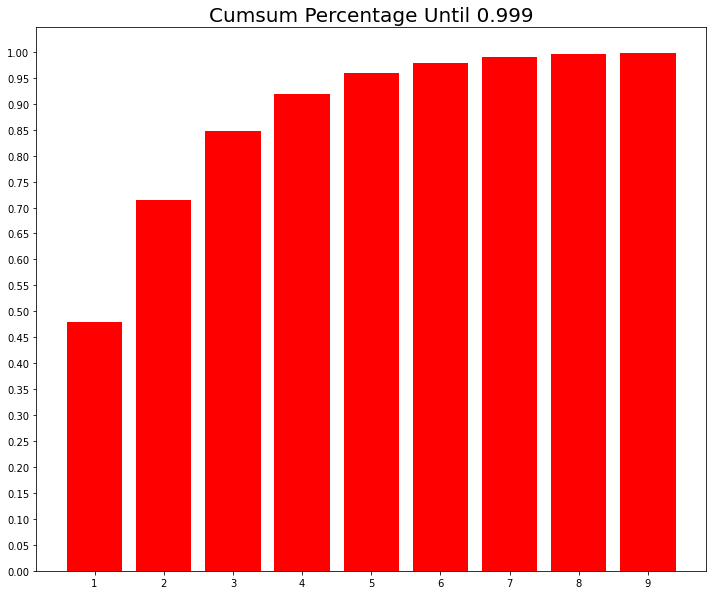

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [21]:
# 위의 이상치 제거
data = data.drop(data[data['SessionId']==long_session].index)
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId


## session time

In [22]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


## Data Cleansing

In [23]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [24]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,SessionId
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
7,1,2804,5,2000-12-31 22:11:59,5
8,1,1207,4,2000-12-31 22:11:59,5
...,...,...,...,...,...
1000189,6040,3362,4,2001-08-10 14:29:56,471145
1000190,6040,3421,3,2001-08-10 14:31:49,471146
1000191,6040,1258,4,2001-08-10 14:31:49,471146
1000205,6040,1921,4,2001-08-10 14:41:04,471160


In [25]:
rate = data.groupby('Rating')['ItemId'].count()
rate

Rating
1     43369
2     82710
3    203306
4    269512
5    174308
Name: ItemId, dtype: int64

In [26]:
# 1,2점 영화가 소수이고 추천에 큰 도움이 못 되므로 제거
data = data[data['Rating'] >= 3]
rate = data.groupby('Rating')['ItemId'].count()
rate

Rating
3    203306
4    269512
5    174308
Name: ItemId, dtype: int64

## Train / Valid / Test split

In [27]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [28]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [29]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [30]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 643105
	 Sessions: 232660
	 Items: 3322
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2002-08-11 14:28:02

* valid Set Stats Info
	 Events: 2141
	 Sessions: 924
	 Items: 1164
	 First Time : 2002-08-14 07:10:28
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 1880
	 Sessions: 834
	 Items: 1060
	 First Time : 2002-11-21 01:02:06
	 Last Time : 2003-02-28 17:49:08



In [31]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [32]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. 미니 배치의 구성

## SessionDataset

In [37]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [38]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,2000-12-31 22:00:55,1,0
2,1,1721,4,2000-12-31 22:00:55,1,1
3,1,1022,5,2000-12-31 22:00:55,1,2
7,1,2804,5,2000-12-31 22:11:59,5,3
8,1,1207,4,2000-12-31 22:11:59,5,4
9,1,1193,5,2000-12-31 22:12:40,6,5
10,1,720,3,2000-12-31 22:12:40,6,6
11,1,260,4,2000-12-31 22:12:40,6,7
19,1,1035,5,2000-12-31 22:29:13,14,8
20,1,1962,4,2000-12-31 22:29:13,14,9


In [39]:
tr_dataset.click_offsets

array([     0,      3,      5, ..., 643101, 643103, 643105], dtype=int32)

In [40]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 232657, 232658, 232659])

## SessionDataLoader

In [41]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [42]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,2000-12-31 22:00:55,1,0
2,1,1721,4,2000-12-31 22:00:55,1,1
3,1,1022,5,2000-12-31 22:00:55,1,2
7,1,2804,5,2000-12-31 22:11:59,5,3
8,1,1207,4,2000-12-31 22:11:59,5,4
9,1,1193,5,2000-12-31 22:12:40,6,5
10,1,720,3,2000-12-31 22:12:40,6,6
11,1,260,4,2000-12-31 22:12:40,6,7
19,1,1035,5,2000-12-31 22:29:13,14,8
20,1,1962,4,2000-12-31 22:29:13,14,9


In [43]:
iter_ex = iter(tr_data_loader)

In [44]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 8]
Label Item Idx are :       [1 4 6 9]
Previous Masked Input Idx are []


# 3. 모델 구성

* MRR과 Recall@k를 사용

In [45]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [47]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [52]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [53]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3322)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    506100    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3322)               169422    
Total params: 675,522
Trainable params: 675,522
Non-trainable params: 0
_________________________________________________________________


# 4. 모델 학습

In [54]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [55]:
train_model(model, args)

Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.63it/s]


	 - Recall@20 epoch 1: 0.120117
	 - MRR@20    epoch 1: 0.034145



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.91it/s]


	 - Recall@20 epoch 2: 0.168945
	 - MRR@20    epoch 2: 0.054652



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.90it/s]


	 - Recall@20 epoch 3: 0.186523
	 - MRR@20    epoch 3: 0.063866



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.92it/s]


	 - Recall@20 epoch 4: 0.192383
	 - MRR@20    epoch 4: 0.068980



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.98it/s]


	 - Recall@20 epoch 5: 0.203125
	 - MRR@20    epoch 5: 0.071793



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.94it/s]


	 - Recall@20 epoch 6: 0.211914
	 - MRR@20    epoch 6: 0.072489



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.96it/s]


	 - Recall@20 epoch 7: 0.210938
	 - MRR@20    epoch 7: 0.071649



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.95it/s]


	 - Recall@20 epoch 8: 0.210938
	 - MRR@20    epoch 8: 0.070597



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.90it/s]


	 - Recall@20 epoch 9: 0.216797
	 - MRR@20    epoch 9: 0.072537



Evaluation:  89%|████████▉ | 8/9 [00:04<00:00,  1.98it/s]

	 - Recall@20 epoch 10: 0.211914
	 - MRR@20    epoch 10: 0.071426



# 5. 모델 테스트

In [56]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  88%|████████▊ | 7/8 [00:03<00:00,  2.03it/s]

	 - Recall@20: 0.277902
	 - MRR@20: 0.104501



# 회고

* 너무 어려운 노드였다. 논문을 읽고 직접 공부하는게 아직도 힘든 모양이다.
* 따라가기에 급급해 다양한 시도가 힘들었다.